---
title: Statistical Downscaling and Bias-Adjustment - Advanced tools
---


The previous notebook covered the most common utilities of `xsdba` for conventional cases. Here, we explore more advanced usage of `xsdba` tools.

## Optimization with dask

Adjustment processes can be very heavy when we need to compute them over large regions and long timeseries. Using small groupings (like `time.dayofyear`) adds precision and robustness, but also decouples the load and computing complexity. Fortunately, unlike the heroic pioneers of scientific computing who managed to write parallelized FORTRAN, we now have [dask](https://dask.org/). With only a few parameters, we can magically distribute the computing load to multiple workers and threads.

A good first read on the use of dask within xarray are the latter's [Optimization tips](https://xarray.pydata.org/en/stable/user-guide/dask.html#optimization-tips).

Some `xsdba`-specific tips:

* Most adjustment method will need to perform operation on the whole `time` coordinate, so it is best to optimize chunking along the other dimensions. This is often different from how public data is shared, where more universal 3D chunks are used.

    Chunking of outputs can be controlled in xarray's [to_netcdf](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html?highlight=to_netcdf#xarray.Dataset.to_netcdf). We also suggest using [Zarr](https://zarr.readthedocs.io/en/stable/) files. According to [its creators](https://ui.adsabs.harvard.edu/abs/2018AGUFMIN33A..06A/abstract), `zarr` stores should give better performances, especially because of their better ability for parallel I/O. See [Dataset.to_zarr](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_zarr.html?highlight=to_zarr#xarray.Dataset.to_zarr) and this useful [rechunking package](https://rechunker.readthedocs.io).


<!-- FIXME : Do we leave the mention of xclim-0.27 as-is, give more context? -->
* One of the main bottleneck for adjustments with small groups is that dask needs to build and optimize an enormous task graph. This issue has been greatly reduced with `xclim` 0.27 and the use of `map_blocks` in the adjustment methods. However, not all adjustment methods use this optimized syntax.

    In order to help dask, one can split the processing in parts. For splitting training and adjustment, see [the section below](#Initializing-an-Adjustment-object-from-a-training-dataset).


* Another massive bottleneck of parallelization of `xarray` is the thread-locking behaviour of some methods. It is quite difficult to isolate and avoid these locking instances, so one of the best workarounds is to use `dask` configurations with many _processes_ and few _threads_. The former do not share memory and thus are not impacted when a lock is activated from a thread in another worker. However, this adds many memory transfer operations and, by experience, reduces dask's ability to parallelize some pipelines. Such a dask Client is usually created with a large `n_workers` and a small `threads_per_worker`.


* Sometimes, datasets have auxiliary coordinates (for example : lat / lon in a rotated pole dataset). Xarray handles these variables as data variables and will **not** load them if dask is used. However, in some operations, `xsdba` or `xarray` will trigger access to those variables, triggering computations each time, since they are `dask`-based. To avoid this behaviour, one can load the coordinates, or simply remove them from the inputs.


## LOESS smoothing and detrending

As described in Cleveland (1979), locally weighted linear regressions are multiple regression methods using a nearest-neighbour approach. Instead of using all data points to compute a linear or polynomial regression, LOESS algorithms compute a local regression for each point in the dataset, using only the k-nearest neighbours as selected by a weighting function. This weighting function must fulfill some strict requirements, see the doc of `xsdba.loess.loess_smoothing` for more details.

In `xsdba`'s implementation, the user can choose between local _constancy_ ($d=0$, local estimates are weighted averages) and local _linearity_ ($d=1$, local estimates are taken from linear regressions). Two weighting functions are currently implemented : "tricube" ($w(x) = (1 - x^3)^3$) and "gaussian" ($w(x) = e^{-x^2 / 2\sigma^2}$). Finally, the number of Cleveland's _robustifying iterations_ is controllable through `niter`. After computing an estimate of $y(x)$, the weights are modulated by a function of the distance between the estimate and the points and the procedure is started over. These iterations are made to weaken the effect of outliers on the estimate.

The next example shows the application of the LOESS to daily temperature data. The black line and dot are the estimated $y$, outputs of the `xsdba.loess.loess_smoothing` function, using local linear regression (passing $d = 1$), a window spanning 20% ($f = 0.2$) of the domain, the "tricube" weighting function and only one iteration. The red curve illustrates the weighting function on January 1st 2014, where the red circles are the nearest-neighbours used in the estimation.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import nc_time_axis
import numpy as np
import xarray as xr

from xsdba import loess

%matplotlib inline
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (11, 5)

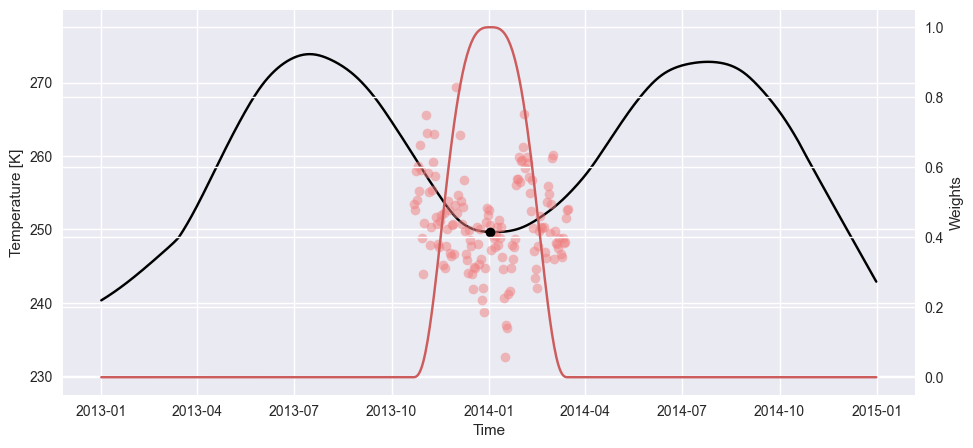

In [2]:
# Daily temperature data from xarray's tutorials
ds = xr.tutorial.open_dataset("air_temperature").resample(time="D").mean()
tas = ds.isel(lat=0, lon=0).air

# Compute the smoothed series
f = 0.2
ys = loess.loess_smoothing(tas, d=1, weights="tricube", f=f, niter=1)

# Plot data points and smoothed series
fig, ax = plt.subplots()
ax.plot(tas.time, tas, "o", fillstyle="none")
ax.plot(tas.time, ys, "k")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature [K]")

## The code below calls internal functions to demonstrate how the weights are computed.

# LOESS algorithms as implemented here use scaled coordinates.
x = tas.time
x = (x - x[0]) / (x[-1] - x[0])
xi = x[366]
ti = tas.time[366]

# Weighting function take the distance with all neighbors scaled by the r parameter as input
r = int(f * tas.time.size)
h = np.sort(np.abs(x - xi))[r]
weights = loess._tricube_weighting(np.abs(x - xi).values / h)

# Plot nearest neighbors and weighing function
wax = ax.twinx()
wax.plot(tas.time, weights, color="indianred")
ax.plot(
    tas.time, tas.where(tas * weights > 0), "o", color="lightcoral", alpha=0.5
)

ax.plot(ti, ys[366], "ko")
wax.set_ylabel("Weights")
plt.show()

LOESS smoothing can suffer from heavy boundary effects. On the previous graph, we can associate the strange bend on the left end of the line to them. The next example shows a stronger case. Usually, $\frac{f}{2}N$ points on each side should be discarded. On the other hand, LOESS has the advantage of always staying within the bounds of the data.


### LOESS Detrending

In climate science, it can be used in the detrending process. `xsdba` provides `xsdba.detrending.LoessDetrend` in order to compute trend with the LOESS smoothing and remove them from timeseries.

First we create some toy data with a sinusoidal annual cycle, random noise and a linear temperature increase.

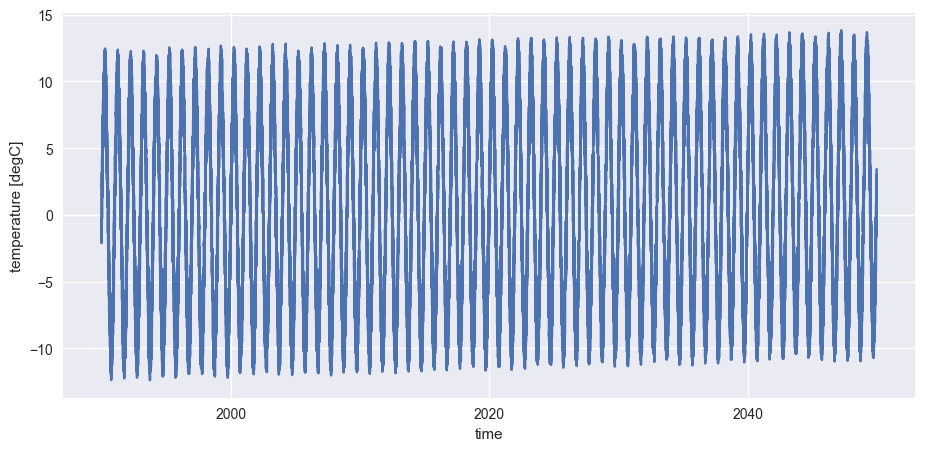

In [3]:
time = xr.cftime_range("1990-01-01", "2049-12-31", calendar="noleap")
tas = xr.DataArray(
    (
        10 * np.sin(time.dayofyear * 2 * np.pi / 365)
        + 5 * (np.random.random_sample(time.size) - 0.5)  # Annual variability
        + np.linspace(0, 1.5, num=time.size)  # Random noise
    ),  # 1.5 degC increase in 60 years
    dims=("time",),
    coords={"time": time},
    attrs={"units": "degC"},
    name="temperature",
)
tas.plot()

Then we compute the trend on the data. Here, we compute on the whole timeseries (`group='time'`) with the parameters suggested above.

In [4]:
from xsdba.detrending import LoessDetrend

# Create the detrending object
det = LoessDetrend(group="time", d=0, niter=2, f=0.2)
# Fitting returns a new object and computes the trend.
fit = det.fit(tas)
# Get the detrended series
tas_det = fit.detrend(tas)

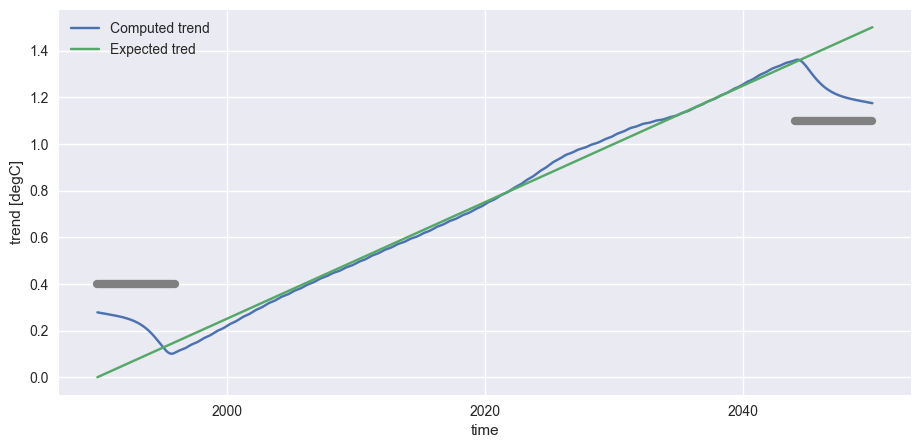

In [5]:
fig, ax = plt.subplots()
fit.ds.trend.plot(ax=ax, label="Computed trend")
ax.plot(time, np.linspace(0, 1.5, num=time.size), label="Expected tred")
ax.plot([time[0], time[int(0.1 * time.size)]], [0.4, 0.4], linewidth=6, color="gray")
ax.plot([time[-int(0.1 * time.size)], time[-1]], [1.1, 1.1], linewidth=6, color="gray")
ax.legend()

As said earlier, this example shows how the Loess has strong boundary effects. It is recommended to remove the $\frac{f}{2}\cdot N$ outermost points on each side, as shown by the  gray bars in the graph above.

## Initializing an Adjustment object from a training dataset

For large scale uses, when the training step deserves its own computation and write to disk, or simply when there are multiples `sim` to be adjusted with the same training, it is helpful to be able to instantiate the Adjustment objects from the training dataset itself. This trick relies on a global attribute "adj_params" set on the training dataset.

In [6]:
import numpy as np
import xarray as xr

# Create toy data for the example, here fake temperature timeseries
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")
ref = xr.DataArray(
    (
        -20 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.1 * (t - t[0]).days / 365
    ),  # "warming" of 1K per decade,
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)
sim = xr.DataArray(
    (
        -18 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.11 * (t - t[0]).days / 365
    ),  # "warming" of 1.1K per decade
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)

ref = ref.sel(time=slice(None, "2015-01-01"))
hist = sim.sel(time=slice(None, "2015-01-01"))

In [7]:
from xsdba.adjustment import QuantileDeltaMapping

QDM = QuantileDeltaMapping.train(
    ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
)
QDM

QuantileDeltaMapping(group=Grouper(name='time.dayofyear'), kind='+')

The trained `QDM` exposes the training data in the `ds` attribute, Here, we will write it to disk, read it back and initialize a new object from it. Notice the `adj_params` in the dataset, that has the same value as the repr string printed just above. Also, notice the `_xsdba_adjustment` attribute that contains a JSON string, so we can rebuild the adjustment object later.

In [8]:
QDM.ds

<xarray.Dataset> Size: 91kB
Dimensions:    (dayofyear: 365, quantiles: 15)
Coordinates:
  * quantiles  (quantiles) float64 120B 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    af         (dayofyear, quantiles) float64 44kB -1.268 -1.415 ... -2.264
    hist_q     (dayofyear, quantiles) float64 44kB 255.7 255.9 ... 258.0 258.5
Attributes:
    group:               time.dayofyear
    group_compute_dims:  ['time']
    group_window:        1
    _xsdba_adjustment:   {"py/object": "xsdba.adjustment.QuantileDeltaMapping...
    adj_params:          QuantileDeltaMapping(group=Grouper(name='time.dayofy...

In [9]:
# The engine keyword is only needed if netCDF4 is not available
# FIXME: Error when using  h5netcdf
# QDM.ds.to_netcdf("QDM_training.nc", engine="h5netcdf")
! rm "QDM_training.nc"
QDM.ds.to_netcdf("QDM_training.nc")
ds = xr.open_dataset("QDM_training.nc")
QDM2 = QuantileDeltaMapping.from_dataset(ds)
QDM2

QuantileDeltaMapping(group=Grouper(name='time.dayofyear'), kind='+')

In the case above, creating a full object from the dataset doesn't make the most sense since we are in the same python session, with the "old" object still available. This method effective when we reload the training data in a different python session, say on another computer. **However, take note that there is no retro-compatibility insurance.** If the `QuantileDeltaMapping` class was to change in a new `xsdba` version, one would not be able to create the new object from a dataset saved with the old one.

For the case where we stay in the same python session, it is still useful to trigger the dask computations. For small datasets, that could mean a simple `QDM.ds.load()`, but sometimes even the training data is too large to be full loaded in memory. In that case, we could also do:

In [10]:
# FIXME: Error when using  h5netcdf
# QDM.ds.to_netcdf("QDM_training2.nc", engine="h5netcdf")
! rm "QDM_training2.nc"
QDM.ds.to_netcdf("QDM_training2.nc")
ds = xr.open_dataset("QDM_training2.nc")
ds.attrs["title"] = "This is the dataset, but read from disk."
QDM.set_dataset(ds)
QDM.ds

<xarray.Dataset> Size: 91kB
Dimensions:    (dayofyear: 365, quantiles: 15)
Coordinates:
  * quantiles  (quantiles) float64 120B 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    af         (dayofyear, quantiles) float64 44kB ...
    hist_q     (dayofyear, quantiles) float64 44kB ...
Attributes:
    group:               time.dayofyear
    group_compute_dims:  time
    group_window:        1
    _xsdba_adjustment:   {"py/object": "xsdba.adjustment.QuantileDeltaMapping...
    adj_params:          QuantileDeltaMapping(group=Grouper(name='time.dayofy...
    title:               This is the dataset, but read from disk.

In [11]:
QDM2.adjust(sim)

<xarray.DataArray 'scen' (time: 11315)> Size: 91kB
array([255.23206044, 254.31691855, 254.849451  , ..., 257.95004657,
       257.05566815, 256.34753035])
Coordinates:
  * time     (time) object 91kB 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:            K
    history:          [2024-08-02 12:24:44] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time.dayofyear...

## Retrieving extra output diagnostics

<!-- TODO : check xsdba_extra_output works -->

To fully understand what is happening during the bias-adjustment process, `xsdba` can output _diagnostic_ variables, giving more visibility to what the adjustment is doing behind the scene. This behaviour, a `verbose` option, is controlled by the `xsdba_extra_output` option, set with `xsdba.set_options`. When `True`, `train` calls are instructed to include additional variables to the training datasets. In addition, the `adjust` calls will always output a dataset, with `scen` and, depending on the algorithm, other diagnostics variables. See the documentation of each `Adjustment` objects to see what extra variables are available.

For the moment, this feature is still under construction and only a few `Adjustment` actually provide these extra outputs. Please open issues on the GitHub repo if you have needs or ideas of interesting diagnostic variables.

For example, `QDM.adjust` adds `sim_q`, which gives the quantile of each element of `sim` within its group.

In [12]:
from xsdba import set_options

with set_options(xsdba_extra_output=True):
    QDM = QuantileDeltaMapping.train(
        ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
    )
    out = QDM.adjust(sim)

out.sim_q

<xarray.DataArray 'sim_q' (time: 11315)> Size: 91kB
array([0.23333333, 0.13333333, 0.2       , ..., 1.        , 0.8       ,
       0.7       ])
Coordinates:
  * time     (time) object 91kB 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    group:               time.dayofyear
    group_compute_dims:  time
    group_window:        1
    long_name:           Group-wise quantiles of `sim`.

## Moving window for adjustments

Some Adjustment methods require that the adjusted data (`sim`) be of the same length (same number of points) than the training data (`ref` and `hist`). These requirements often ensure conservation of statistical properties and a better representation of the climate change signal over the long adjusted timeseries.

In opposition to a conventional "rolling window", here it is the _years_ that are the base units of the window, not the elements themselves. `xsdba` implements `xsdba.calendar.stack_periods` and `xsdba.calendar.unstack_periods` to manipulate data in that goal. The "stack" function cuts the data in overlapping windows of a certain length and stacks them along a new `"period"` dimension, alike to xarray's `da.rolling(time=win).construct('period')`, but with yearly steps. The stride (or step) between each window can also be controlled. This argument is an indicator of how many years overlap between each window. With a value of `1`, a window will have `window - 1` years overlapping with the previous one. The default (`None`) is to have `stride = window` will result in no overlap at all. The default units in which `window` and `stride` are given is a year ("YS"), but can be changed with argument `freq`.

By chunking the result along this `'period'` dimension, it is expected to be more computationally efficient (when using `dask`) than looping over the windows with a for-loop (or a `GroupyBy`)

Note that this results in two restrictions:

1. The constructed array has the same "time" axis for all windows. This is a problem if the actual _year_ is of importance for the adjustment, but this is not the case for any of `xsdba`'s current adjustment methods.
2. The input timeseries must be in a calendar with uniform year lengths. For daily data, this means only the "360_day", "noleap" and "all_leap" calendars are supported.

The "unstack" function does the opposite: it concatenates the windows together to recreate the original timeseries. It only works for the no-overlap case where `stride = window` and for the non-ambiguous one where `stride` divides `window` into an odd number (N) of parts. In that latter situation, the middle parts of each period are kept when reconstructing the timeseries, in addition to the first (last) parts of the first (last) period needed to get a full timeseries.

Quantile Delta Mapping requires that the adjustment period should be of a length similar to the training one. As our `ref` and `hist` cover 15 years but `sim` covers 31 years, we will transform `sim` by stacking windows of 15 years. With a stride of five (5) years, this means the first window goes from 2000 to 2014 (inclusive). Then 2005-2019, 2010-2024 and 2015-2029. The last year will be dropped as it can't be included in any complete window.

<div class="alert alert-warning">

In the following example, `QDM` is configured with `group="time.dayofyear"` which will perform the adjustment for each day of year (doy) separately. When using `stack_periods` the extracted windows are all concatenated along the new `period` axis, and they all share the same time coordinate. As such, for the `doy` information to make sense, we must use a calendar with uniform year lengths. Otherwise, the `doy` values would shift one day at each leap year.

</div>

In [13]:
QDM = QuantileDeltaMapping.train(
    ref, hist, nquantiles=15, kind="+", group="time.dayofyear"
)

scen_nowin = QDM.adjust(sim)

In [14]:
from xsdba.calendar import stack_periods, unstack_periods

sim_win = stack_periods(sim, window=15, stride=5)
sim_win

<xarray.DataArray (period: 4, time: 5475)> Size: 175kB
array([[256.56897873, 256.33204916, 256.6078032 , ..., 258.27778118,
        257.92444362, 258.72658245],
       [256.34414151, 255.9003116 , 257.24846488, ..., 258.4266159 ,
        258.18310965, 259.22809524],
       [257.29972639, 256.88057295, 258.17260583, ..., 258.73870093,
        258.79702384, 259.01007664],
       [258.54563373, 257.32674304, 258.74673108, ..., 259.76399892,
        260.03250936, 259.81183198]])
Coordinates:
  * time           (time) object 44kB 1970-01-01 00:00:00 ... 1984-12-31 00:0...
    period_length  (period) int64 32B 5475 5475 5475 5475
  * period         (period) object 32B 2000-01-01 00:00:00 ... 2015-01-01 00:...
Attributes:
    units:    K

Here, we retrieve the full timeseries (minus the lasy year that couldn't fit in any window).

In [15]:
scen_win = unstack_periods(QDM.adjust(sim_win))
scen_win

<xarray.DataArray 'scen' (time: 10950)> Size: 88kB
array([255.22055623, 254.25554953, 255.03477622, ..., 257.79550951,
       258.28040379, 257.54786958])
Coordinates:
  * time     (time) object 88kB 2000-01-01 00:00:00 ... 2029-12-31 00:00:00
Attributes:
    units:            K
    history:          [2024-08-02 12:24:53] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time.dayofyear...

## Full example: Multivariate adjustment in the additive space

The following example shows a complete bias-adjustment workflow using the `PrincipalComponents` method in a multi-variate configuration. Moreover, it uses the trick showed by [Alavoine et Grenier (2022)](https://doi.org/10.31223/X5C34C) to transform "multiplicative" variable to the "additive" space using log and logit transformations. This way, we can perform multi-variate adjustment with variables that couldn't be used in the same _kind_ of adjustment, like "tas" and "hurs".

We will transform the variables that need it to the additive space, adding some jitter in the process to avoid $log(0)$ situations. Then, we will stack the different variables into a single `DataArray`, allowing us to use `PrincipalComponents` in a multi-variate way. Following the PCA, a simple quantile-mapping method is used, both adjustment acting on the residuals, while the mean of the simulated trend is adjusted on its own. Each step will be explained.

First, open the data, convert the calendar and the units. Because we will perform adjustments on "dayofyear" groups (with a window), keeping standard calendars results in an extra "dayofyear" with only a quarter of the data. It's usual to transform to a "noleap" calendar, which drops the 29th of February, as it only has a small impact on the data.

In [16]:
import xsdba
from xsdba.calendar import convert_calendar
from xsdba.units import convert_units_to, pint_multiply
from xsdba.testing import open_dataset

group = xsdba.Grouper("time.dayofyear", window=31)

dref = convert_calendar(open_dataset("sdba/ahccd_1950-2013.nc"), "noleap").sel(
    time=slice("1981", "2010")
)
dsim = open_dataset("sdba/CanESM2_1950-2100.nc")

dref = dref.assign(
    tasmax=convert_units_to(dref.tasmax, "K"),
)
inverse_water_density = "1e-03 m^3/kg"
dsim = dsim.assign(pr=convert_units_to(pint_multiply(dsim.pr, inverse_water_density) , "mm/d"))

/home/eridup1/repos/xsdba/src/xsdba/calendar.py:93: FutureWarning: `xclim` function convert_calendar is deprecated in favour of xarray.coding.calendar_ops.convert_calendar or obj.convert_calendar and will be removed in v0.51.0. Please adjust your script.
  warn(


### 1. Jitter, additive space transformation and variable stacking
Here, `tasmax` is already ready to be adjusted in an additive way, because all data points are far from the physical zero (0 K). This is not the case for `pr`, which is why we want to transform that variable to the additive space, to avoid splitting our workflow in two. For `pr` the "log" transformation is simply:

$$ pr' = \ln\left(pr - b\right) $$

Where $b$ is the lower bound, here 0 mm/d. However, we could have exact zeros (0 mm/d) in the datasets, which will translate into $-\infty$. To avoid this, we simply replace the smallest values by a random distribution of very small, but not problematic, values. In the following, all values below 0.1 mm/d are replaced by a uniform random distribution of values within the range (0, 0.1) mm/d (bounds excluded).

Finally, the variables are stacked together into a single `DataArray`.

In [17]:
dref_as = dref.assign(
    pr=xsdba.processing.to_additive_space(
        xsdba.processing.jitter(dref.pr, lower="0.1 mm/d", minimum="0 mm/d"),
        lower_bound="0 mm/d",
        trans="log",
    )
)
ref = xsdba.stack_variables(dref_as)

dsim_as = dsim.assign(
    pr=xsdba.processing.to_additive_space(
        xsdba.processing.jitter(dsim.pr, lower="0.1 mm/d", minimum="0 mm/d"),
        lower_bound="0 mm/d",
        trans="log",
    )
)
sim = xsdba.stack_variables(dsim_as)
sim

<xarray.DataArray 'multivariate' (multivar: 2, time: 55115, location: 3)> Size: 1MB
array([[[ 2.4951424e-01, -8.2575518e-01,  2.4951424e-01],
        [ 2.6499709e-01, -4.1112199e-01,  2.6499709e-01],
        [-1.9535354e-01, -2.7694762e+00, -1.9535354e-01],
        ...,
        [ 3.2132244e+00, -2.2834629e-01,  3.2132244e+00],
        [ 1.6713389e+00,  1.7489431e+00,  1.6713389e+00],
        [ 7.5195450e-01,  2.4332018e+00,  7.5195450e-01]],

       [[ 2.7815024e+02,  2.7754898e+02,  2.7815024e+02],
        [ 2.8335815e+02,  2.7690921e+02,  2.8335815e+02],
        [ 2.8153192e+02,  2.7668036e+02,  2.8153192e+02],
        ...,
        [ 2.8901334e+02,  2.8192789e+02,  2.8901334e+02],
        [ 2.8510699e+02,  2.8142294e+02,  2.8510699e+02],
        [ 2.8404471e+02,  2.8160156e+02,  2.8404471e+02]]], dtype=float32)
Coordinates:
  * time      (time) object 441kB 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
    lat       (location) float64 24B 49.1 67.8 48.8
    lon       (location) float64 24B -123.1 -115.1 -78.2
  * location  (location) <U9 108B 'Vancouver' 'Kugluktuk' 'Amos'
  * multivar  (multivar) <U6 48B 'pr' 'tasmax'
Attributes: (12/34)
    institution:                     CanESM2
    institute_id:                    CCCma
    experiment_id:                   rcp85
    source:                          CanESM2 2010 atmosphere: CanAM4 (AGCM15i...
    model_id:                        CanESM2
    forcing:                         GHG,Oz,SA,BC,OC,LU,Sl (GHG includes CO2,...
    ...                              ...
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.5.4
    DODS_EXTRA.Unlimited_Dimension:  time
    description:                     Extracted from CMIP5 CanESM2 hist+rcp85 ...
    units:

### 2. Get residuals and trends
The adjustment will be performed on residuals only. The adjusted timeseries `sim` will be detrended with the LOESS routine described above. Because of the short length of  `ref` and `hist` and the potential boundary effects of using LOESS with them, we compute the 30-year mean. In other words, instead of _detrending_ inputs, we are _normalizing_ those inputs.

While the residuals are adjusted with `PrincipalComponents` and `EmpiricalQuantileMapping`, the trend of  `sim` still needs to be offset according to the means of `ref` and `hist`. This is similar to what `DetrendedQuantileMapping` does. The offset step could have been done on the trend itself or at the end on `scen`, it doesn't really matter. We do it here because it keeps it close to where the `scaling` is computed.

In [18]:
ref_res, ref_norm = xsdba.processing.normalize(ref, group=group, kind="+")
hist_res, hist_norm = xsdba.processing.normalize(
    sim.sel(time=slice("1981", "2010")), group=group, kind="+"
)
scaling = xsdba.utils.get_correction(hist_norm, ref_norm, kind="+")

In [19]:
sim_scaled = xsdba.utils.apply_correction(
    sim, xsdba.utils.broadcast(scaling, sim, group=group), kind="+"
)

loess = xsdba.detrending.LoessDetrend(group=group, f=0.2, d=0, kind="+", niter=1)
simfit = loess.fit(sim_scaled)
sim_res = simfit.detrend(sim_scaled)

### 3. Adjustments
Following, Alavoine et Grenier (2022), we decided to perform the multivariate Principal Components adjustment first and then re-adjust with the simple Quantile-Mapping.

In [20]:
PCA = xsdba.adjustment.PrincipalComponents.train(
    ref_res, hist_res, group=group, crd_dim="multivar", best_orientation="simple"
)

scen1_res = PCA.adjust(sim_res)

In [21]:
EQM = xsdba.adjustment.EmpiricalQuantileMapping.train(
    ref_res,
    scen1_res.sel(time=slice("1981", "2010")),
    group=group,
    nquantiles=50,
    kind="+",
)

scen2_res = EQM.adjust(scen1_res, interp="linear", extrapolation="constant")

### 4. Re-trend and transform back to the physical space
Add back the trend (which includes the scaling), unstack the variables to a dataset and transform `pr` back to the physical space. All functions have conserved and handled the attributes, so we don't need to repeat the additive space bounds. The annual cycle of both variables on the reference period in Vancouver is plotted to confirm the adjustment adds a positive effect.

In [22]:
scen = simfit.retrend(scen2_res)
dscen_as = xsdba.unstack_variables(scen)
dscen = dscen_as.assign(pr=xsdba.processing.from_additive_space(dscen_as.pr))

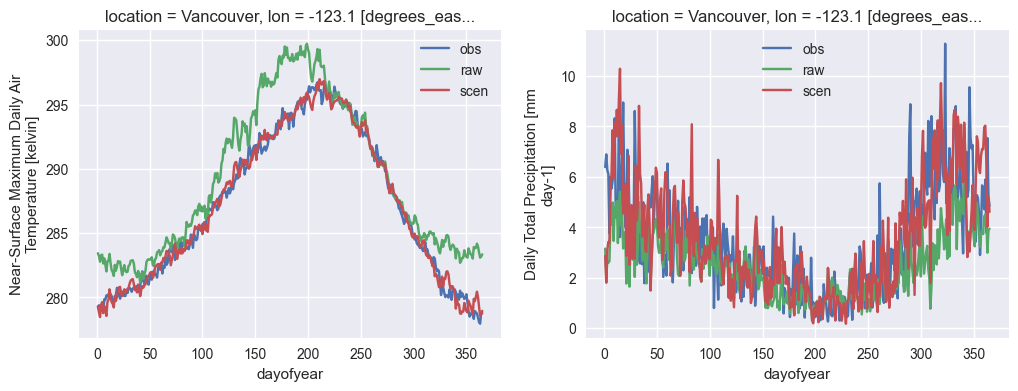

In [23]:
# gather data together for plotting
dsl = [ds.assign_coords({"data_type":lab}) for ds, lab in zip([dref,dsim,dscen], ["obs", "raw", "scen"])]
dsout = xr.concat(dsl, dim="data_type")

fig, axs = plt.subplots(1,2, figsize=(12,4))
fg = dsout.tasmax.sel(time=slice("1981", "2010"), location="Vancouver").groupby(
    "time.dayofyear"
).mean().plot(hue="data_type",ax=axs[0])
axs[0].get_legend().set_title('')
dsout.pr.sel(time=slice("1981", "2010"), location="Vancouver").groupby(
    "time.dayofyear"
).mean().plot(hue="data_type",ax=axs[1])
axs[1].get_legend().set_title('')

# Frequency adaption with a rolling window

In the previous example, we performed bias adjustment with a rolling window. Here we show how to include frequency adaptation (see `example.ipynb` for the simple case `group="time"`). We first generate the same precipitation dataset used in `example.ipynb`

In [24]:
import numpy as np
import xarray as xr

t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")

vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals / 100, vals)) / 3e6
vals_sim = (
    (1 + 0.1 * np.random.random_sample((t.size,)))
    * (4 ** np.where(vals < 9.5, vals / 100, vals))
    / 3e6
)

pr_ref = xr.DataArray(
    vals_ref, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_ref = pr_ref.sel(time=slice("2000", "2015"))
pr_sim = xr.DataArray(
    vals_sim, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_hist = pr_sim.sel(time=slice("2000", "2015"))

Bias adjustment on a rolling window can be performed in the same way as shown in `example.ipynb`, but instead of being a single string precising the time grouping (e.g. `time.month`), the `group` argument is built with `sdba.Grouper` function

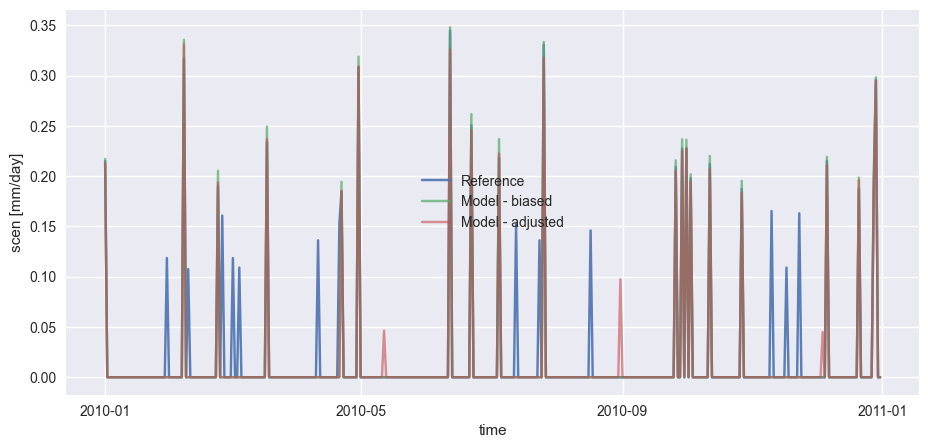

In [25]:
import matplotlib.pyplot as plt

# adapt_freq with a xsdba.Grouper
import xsdba

group = xsdba.Grouper("time.dayofyear", window=31)
hist_ad, pth, dP0 = xsdba.processing.adapt_freq(
    pr_ref, pr_hist, thresh="0.05 mm d-1", group=group
)
QM_ad = xsdba.EmpiricalQuantileMapping.train(
    pr_ref, hist_ad, nquantiles=15, kind="*", group=group
)
scen_ad = QM_ad.adjust(pr_sim)

pr_ref.sel(time="2010").plot(alpha=0.9, label="Reference")
pr_sim.sel(time="2010").plot(alpha=0.7, label="Model - biased")
scen_ad.sel(time="2010").plot(alpha=0.6, label="Model - adjusted")
plt.legend()

In the figure above, `scen` occasionally has small peaks where `sim` is 0, indicating that there are more "dry days" (days with almost no precipitation) in `hist` than in `ref`. The frequency-adaptation [Themeßl et al. (2010)](https://doi.org/10.1007/s10584-011-0224-4) performed in the step above only worked partially.  

The reason for this is the following. The first step above combines precipitations in 365 overlapping blocks of 31 days * Y years, one block for each day of the year. Each block is adapted, and the 16th day-of-year slice (at the center of the block) is assigned to the corresponding day-of-year in the adapted dataset `hist_ad`. As we proceed to the training, we re-form those 31 days * Y years blocks, but this step does not invert the last one: There can still be more zeroes in the simulation than in the reference. 

To alleviate this issue, another way of proceeding is to perform a frequency adaptation on the blocks, and then use the same blocks in the training step, as we show below.

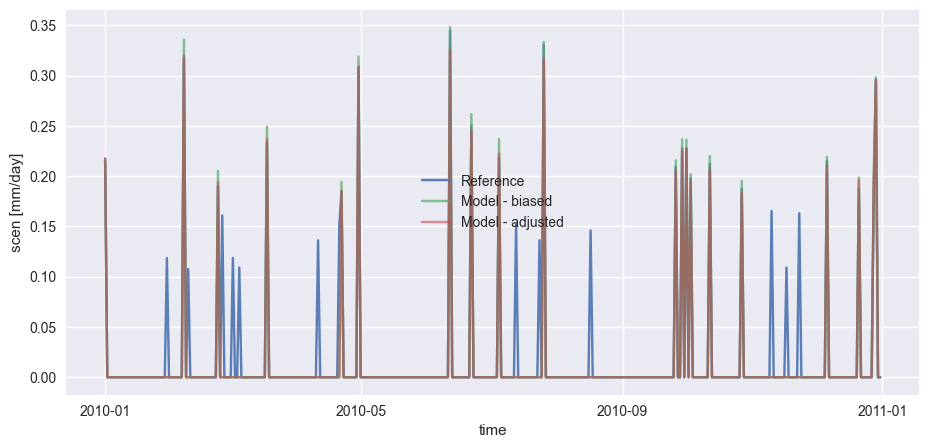

In [26]:
# adapt_freq directly in the training step
group = xsdba.Grouper("time.dayofyear", window=31)

QM_ad = xsdba.EmpiricalQuantileMapping.train(
    pr_ref,
    pr_hist,
    nquantiles=15,
    kind="*",
    group=group,
    adapt_freq_thresh="0.05 mm d-1",
)
scen_ad = QM_ad.adjust(pr_sim)

pr_ref.sel(time="2010").plot(alpha=0.9, label="Reference")
pr_sim.sel(time="2010").plot(alpha=0.7, label="Model - biased")
scen_ad.sel(time="2010").plot(alpha=0.6, label="Model - adjusted")
plt.legend()

## Tests for sdba

It can be useful to perform diagnostic tests on adjusted simulations to assess if the bias correction method is working properly, or to compare two different bias correction techniques.

A diagnostic test includes calculations of a property (mean, 20-year return value, annual cycle amplitude, ...) on the simulation and on the scenario (adjusted simulation), then a measure (bias, relative bias, ratio, ...) of the  difference. Usually, the property collapse the time dimension of the simulation/scenario and returns one value by grid point.

You'll find those in ``xsdba.properties`` and ``xsdba.measures``, where they are implemented as classes similiar to of `xclim`'s ``Indicator``, which means they can be worked with the same way as conventional indicators (used in YAML modules for example).

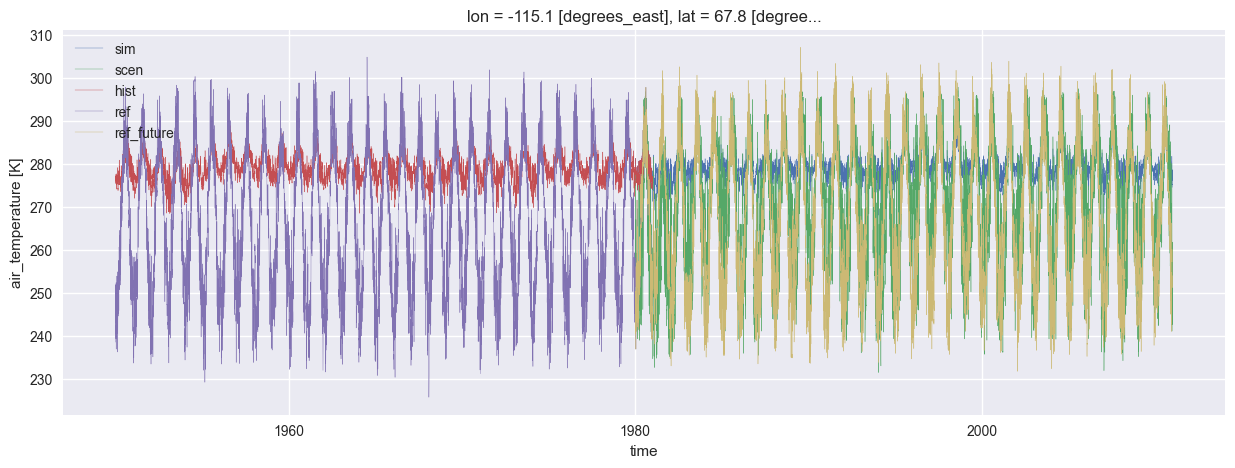

In [27]:
from matplotlib import pyplot as plt

import xsdba
from xsdba.testing import open_dataset

# load test data
hist = open_dataset("sdba/CanESM2_1950-2100.nc").sel(time=slice("1950", "1980")).tasmax
ref = open_dataset("sdba/nrcan_1950-2013.nc").sel(time=slice("1950", "1980")).tasmax
sim = (
    open_dataset("sdba/CanESM2_1950-2100.nc").sel(time=slice("1980", "2010")).tasmax
)  # biased

# learn the bias in historical simulation compared to reference
QM = xsdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=50, group="time", kind="+"
)

# correct the bias in the future
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")
ref_future = (
    open_dataset("sdba/nrcan_1950-2013.nc").sel(time=slice("1980", "2010")).tasmax
)  # truth

plt.figure(figsize=(15, 5))
lw = 0.3
sim.isel(location=1).plot(label="sim", linewidth=lw)
scen.isel(location=1).plot(label="scen", linewidth=lw)
hist.isel(location=1).plot(label="hist", linewidth=lw)
ref.isel(location=1).plot(label="ref", linewidth=lw)
ref_future.isel(location=1).plot(label="ref_future", linewidth=lw)
leg = plt.legend()

(-2.5, 2.5)

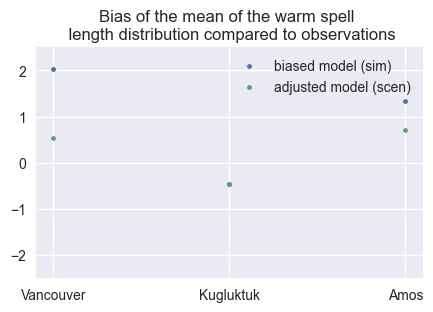

In [28]:
# calculate the mean warm Spell Length Distribution
sim_prop = xsdba.properties.spell_length_distribution(
    da=sim, thresh="28 degC", op=">", stat="mean", group="time"
)


scen_prop = xsdba.properties.spell_length_distribution(
    da=scen, thresh="28 degC", op=">", stat="mean", group="time"
)

ref_prop = xsdba.properties.spell_length_distribution(
    da=ref_future, thresh="28 degC", op=">", stat="mean", group="time"
)
# measure the difference between the prediction and the reference with an absolute bias of the properties
measure_sim = xsdba.measures.bias(sim_prop, ref_prop)
measure_scen = xsdba.measures.bias(scen_prop, ref_prop)

plt.figure(figsize=(5, 3))
plt.plot(measure_sim.location, measure_sim.values, ".", label="biased model (sim)")
plt.plot(measure_scen.location, measure_scen.values, ".", label="adjusted model (scen)")
plt.title(
    "Bias of the mean of the warm spell \n length distribution compared to observations"
)
plt.legend()
plt.ylim(-2.5, 2.5)

It is possible the change the 'group' of the property from 'time' to 'time.season' or 'time.month'.
 This will return 4 or 12 values per grid point, respectively.

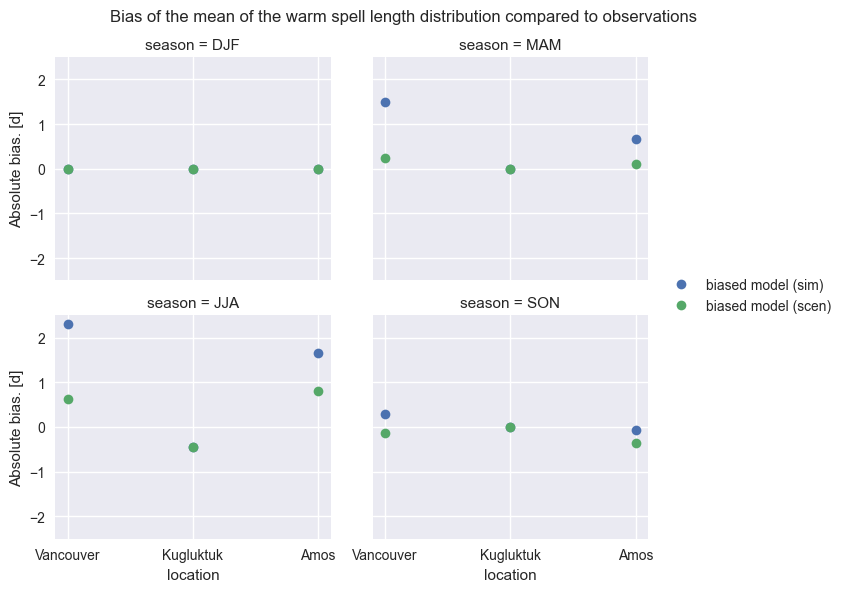

In [29]:
# calculate the mean warm Spell Length Distribution
sim_prop, scen_prop, ref_prop = [xsdba.properties.spell_length_distribution(
    da=ds0, thresh="28 degC", op=">", stat="mean", group="time.season"
) for ds0 in [sim, scen, ref_future]]

# Properties are often associated with the same measures. This correspondence is implemented in xsdba:
measure = xsdba.properties.spell_length_distribution.get_measure()
measure_sim = measure(sim_prop, ref_prop)
measure_scen = measure(scen_prop, ref_prop)

# Gather data together and plot
measl = [meas.assign_coords(data_type=lab) for meas,lab in zip([measure_sim, measure_scen],["biased model (sim)", "biased model (scen)"])]
measure_all = xr.concat(measl, dim="data_type")
fg = measure_all.plot(col="season", col_wrap=2, hue="data_type", marker="o", ls="")
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle(
"Bias of the mean of the warm spell length distribution compared to observations"
)
fg.figlegend.set_title("")
for ax in fg.fig.axes: 
    ax.set_ylim(-2.5,2.5)